In [1]:
import xarray as xr
from cdo import Cdo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import _pickle as cpickle
from functools import reduce
import sys
import seaborn as sns
from scipy.stats import gaussian_kde, norm
from cdo import Cdo
cdo = Cdo()

In [14]:
with open("../../output/pickled_objects/analysis1/precip_new360.pickle", "rb") as loadFile:
    precip_new = cpickle.load(loadFile)

In [2]:
sys.path.append("../scripts/")

In [3]:
from recipes import *

In [75]:
xr.set_options(enable_cftimeindex=True)

In [5]:
def get_directory_structure(rootdir):
    """
    Creates a nested dictionary that represents the folder structure of rootdir
    """
    dir_dict = {}
    rootdir = rootdir.rstrip(os.sep)
    start = rootdir.rfind(os.sep) + 1
    for path, dirs, files in os.walk(rootdir):
        folders = path[start:].split(os.sep)
        subdir = dict.fromkeys(files)
        parent = reduce(dict.get, folders[:-1], dir_dict)
        parent[folders[-1]] = subdir
    return dir_dict

In [6]:
def homo_dims(xr_ds):
    '''A convention for consistent dimension names'''
    if 't' in xr_ds.coords and 'time' not in xr_ds.coords:
        xr_ds = xr_ds.rename({'t': 'time'})
    
    for olddim, newdim in {'longitude': 'lon', 'latitude': 'lat'}.items():
        try:
            xr_ds = xr_ds.rename({olddim: newdim})
        except ValueError:
            pass
        
    return xr_ds

In [13]:
precip_new = get_directory_structure('/home/abhi/Documents/mygit/BC/output/precip/mw30-15/base/')['base']
precip_new = {'mw30-15': precip_new}
threshlist = [0, 0.01, 0.2]
os.chdir('/home/abhi/Documents/mygit/BC/output/precip/mw30-15/base/')

method = 'mw30-15'
for thresh in np.array(threshlist, dtype=str):
    select_dict = precip_new[method][thresh]
    for BCtype in select_dict.keys():
        target_file = f'{thresh}/{BCtype}'
        if '360day' in target_file:
            select_dict[BCtype.replace('_360day', '')] = homo_dims(xr.open_dataset(target_file)).precip
            
            
os.chdir("/home/abhi/Documents/mygit/postBC_diagnostic/src/notebooks")

In [14]:
for method in ['mw30-15']:
    for thresh in ['0', '0.01', '0.2']:
        precip_new[method][thresh] = xr.Dataset(precip_new[method][thresh]).assign_attrs({'threshold': thresh})

In [16]:
with open("../../output/pickled_objects/analysis1/precip_new360.pickle", "wb") as writeFile:
    cpickle.dump(precip_new, writeFile)

In [61]:
mv_xr = precip_new['mw30-15']['0']

varList = select_dict.keys()

for var in varList:
    if '360day' in var:
        mv_xr = mv_xr.drop(var)

In [7]:
data_dir = '/home/abhi/Documents/data'

obs = homo_dims(xr.open_dataset(os.path.join(data_dir, 'OBSERVATION/IMD/precip/imdCAL.nc')))
mod = homo_dims(xr.open_dataset(os.path.join(data_dir, 'PRECIS/base/precip/1971-2000_rm_ll25.nc')))


In [63]:
mv_xr['time'] = obs['time'].copy()
mod['time'] = obs['time'].copy()

In [64]:
mv_xr = mv_xr.assign(obs=obs.precip, raw=mod.precip).drop(["delta", "scaling-additive"])


In [82]:
def RMSE(ds1, da, scale="monthly"):
    mask = (da[0]*0).values
    resampled_M = resample_ms_freq(ds1 - da)
    
    if scale is "monthly":
        return ((resampled_M**2)
                .sum(dim="time"))**(1/2) + mask
    
    elif scale is "seasonal":
        NotImplementedError("")
    
    elif scale is "yearly":
        return ((yearmean(resampled_M)**2)
                .sum(dim="year"))**(1/2) +  mask

In [32]:
%%time
rmse_m = RMSE(mv_xr, obs.precip, scale="monthly").drop("obs")

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/coding/cftimeindex.py:160: FutureWarning: CFTimeIndex.data is deprecated and will be removed in a future version
  if self.data:
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 28.5 s, sys: 10.9 s, total: 39.4 s
Wall time: 4min 33s


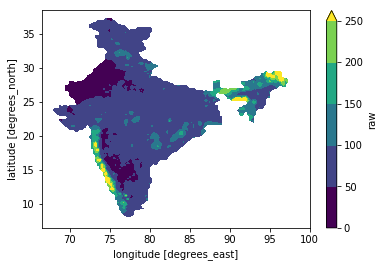

In [78]:
(rmse_m).raw.plot.contourf(levels=range(0, 300, 50))

In [83]:
rmse_y =  RMSE(mv_xr.drop("obs"), obs.precip, scale="yearly")

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/coding/cftimeindex.py:160: FutureWarning: CFTimeIndex.data is deprecated and will be removed in a future version
  if self.data:
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


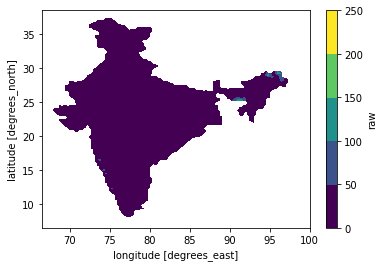

In [85]:
rmse_y.raw.plot.contourf(levels=range(0, 300, 50))

In [87]:
mv_xr_ymean = fldmean(yearmean(mv_xr))

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


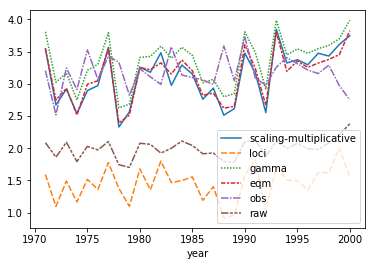

In [92]:
sns.lineplot(data=mv_xr_ymean.to_dataframe())

In [93]:
df = mv_xr_ymean.to_dataframe()



In [171]:
perc_90th = obs.reduce(np.percentile, q=95, dim="time")

/home/abhi/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [112]:
perc_99th = obs.reduce(np.percentile, q=99, dim="time")

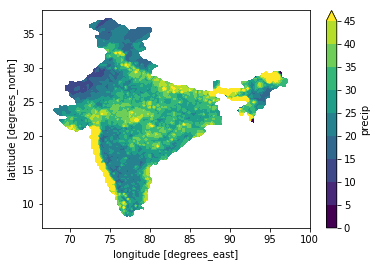

In [172]:
(perc_99th - perc_90th).precip.plot.contourf(levels=np.arange(0, 50, 5))

In [123]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

#### Comparing Distributions of MZI

In [115]:
o = xr.open_dataset("/home/abhi/Documents/data/OBSERVATION/IMD/precip/1901-2017_ll25.nc")

In [156]:
o.indexes['time']

DatetimeIndex(['1901-01-01', '1901-01-02', '1901-01-03', '1901-01-04',
               '1901-01-05', '1901-01-06', '1901-01-07', '1901-01-08',
               '1901-01-09', '1901-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='time', length=42734, freq=None)

In [158]:
period1 = selseas(selyear(sellonlatbox(o, [73, 82, 18, 28]), range(1901, 1951)), "JJAS")
period2 = selseas(selyear(sellonlatbox(o, [73, 82, 18, 28]), range(1971, 2017)), "JJAS")

In [161]:
arr1 = period1.rf.values.flatten()
arr2 = period2.rf.values.flatten()

In [162]:
%time
kernel1 = kde_scipy(arr1, np.linspace(0, 300, 1000))
kernel2 = kde_scipy(arr2, np.linspace(0, 300, 1000))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


In [130]:
arr = norm.rvs(size=1000)
kernel_arr = kde_scipy(arr, np.linspace(-3, 3, 1000))

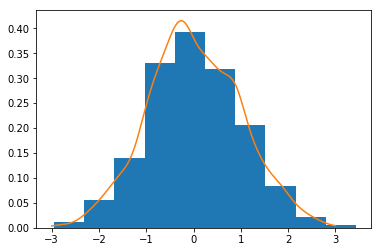

In [133]:
plt.hist(arr, density=True)
plt.plot(np.linspace(-3, 3, 1000), kernel_arr)

(-1, 10)

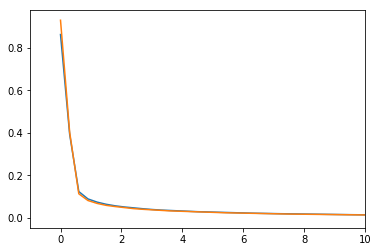

In [166]:
plt.plot(np.linspace(0, 300, 1000), kernel1)
plt.plot(np.linspace(0, 300, 1000), kernel2)
plt.xlim(-1, 10)

In [164]:
from scipy import stats

In [168]:
stats.ks_2samp(arr1, arr2)

Ks_2sampResult(statistic=0.03720072488043563, pvalue=0.0)

### Precipitation indices

#### Change in number of nth percentile days 

In [8]:
rcp_path = lambda scen : f"/home/abhi/Documents/data/PRECIS/{scen}/precip/2021-2090_rm_ll25.nc"

In [9]:
rcp = xr.open_dataset(rcp_path('rcp45')).rename({'precip': 'rcp45'})

rcp = rcp.assign(rcp85=xr.open_dataset(rcp_path('rcp85')).precip)

In [48]:
rcp.to_netcdf("/tmp/rcp")

In [11]:
raw_perc = mod.reduce(np.percentile, q=95, dim="time")

/home/abhi/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


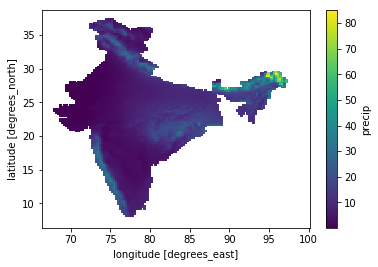

In [47]:
raw_perc.precip.plot()

In [12]:
change_perc = rcp - raw_perc.precip

In [13]:
change_perc.to_netcdf("/tmp/change_perc")

In [19]:
!ncview /tmp/change_perc

Ncview 2.1.6 David W. Pierce  29 Oct 2015
http://meteora.ucsd.edu:80/~pierce/ncview_home_page.html
Copyright (C) 1993 through 2015, David W. Pierce
Ncview comes with ABSOLUTELY NO WARRANTY; for details type `ncview -w'.
This is free software licensed under the Gnu General Public License version 3; type `ncview -c' for redistribution details.

calculating min and maxes for rcp45...
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 3731 requests (3731 known processed) with 0 events remaining.


In [35]:
days_change_t1 = cdo.timsum(input='-gtc,0 -selyear,2021/2050 /tmp/change_perc', 
                         returnCDF=True)

days_change_t2 = cdo.timsum(input='-gtc,0 -selyear,2061/2090 /tmp/change_perc', 
                         returnCDF=True)

In [36]:
days_change_t1 = xr.open_dataset(days_change_t1).mean(["time", "bnds"])
days_change_t2 = xr.open_dataset(days_change_t2).mean(["time", "bnds"])

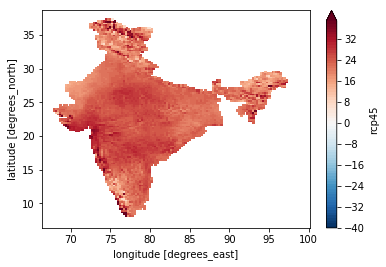

In [44]:
(days_change_t1/30).rcp45.plot(cmap='RdBu_r', levels=np.arange(-40, 40))

In [50]:
raw_file = "/home/abhi/Documents/data/PRECIS/base/precip/1971-2000_rm_ll25.nc"

In [ ]:
ydaypctl_ds = xr.open_dataset(ydaypctl).rename({'t': 'time'})

In [98]:
ydaypctl_ds['time'].values = np.arange(1, 361, 1)

In [99]:
%time
diff = groupbyyday(rcp) - ydaypctl_ds.precip

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


In [101]:
diff['time'] = rcp['time'].copy()

In [106]:
diff.to_netcdf("/tmp/diff")

In [108]:
ydayschange = cdo.timsum(input="-gtc,0 /tmp/diff", returnCDF=True)

In [109]:
ydayschange = xr.open_dataset(ydayschange)

In [115]:
ydayschange = ydayschange.mean(["bnds", "time"]).drop("time_bnds")

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


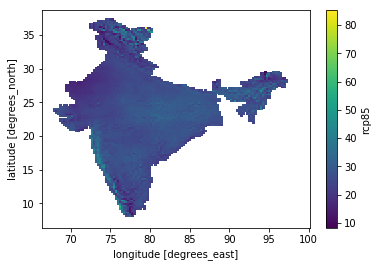

In [119]:
(ydayschange.rcp85/80).plot()